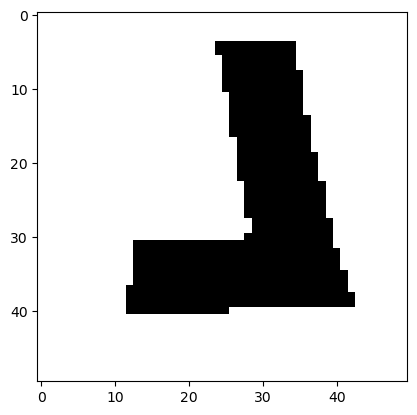

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import pmcx
from scipy.optimize import curve_fit
from cv2 import resize
import cv2
import os
from tqdm import tqdm
from scipy.signal import fftconvolve

#%% read and process obj image, note the obj image is capture from the galvo view
data_fold = r'F:\OneDrive\UK_projects_local\project in UK 2024\diffuse_experiment241021\zhiguan_data\XL_measurement_061224'
obj_img_path = os.path.join(data_fold, 'L_061224.bmp')
obj_img = plt.imread(obj_img_path)

#---------------get the obj ROI defined by the nine holes-----------
obj_img_10x10 = obj_img[360:720, 827:1188]
obj_img_10x10 = obj_img_10x10/obj_img_10x10.max()
obj_img_10x10[obj_img_10x10<0.5] = 0   # keep the obj as zero,in MCX a photon is terminated when moving from a non-zero to zero voxel.
obj_img_10x10[obj_img_10x10>=0.5] = 1

#---------------find the centre from the top, bottom and side of the image edges (10x10)cm----------
pix_ratio = np.round(np.mean([obj_img_10x10.shape[0], obj_img_10x10.shape[1]])/10)
from_top = np.round((1.75 + 2.5)*pix_ratio).astype('int') # center pixel to top edge in obj_img_10x10 measured in pixel scale
from_bot = np.round((10 - 1.75 - 2.5)*pix_ratio).astype('int') # center pixel to bottom edge in obj_img_10x10 measured in pixel scale
from_side = np.round(5*pix_ratio).astype('int') # center pixel to side edge in obj_img_10x10 measured in pixel scale
pix_4cm = np.round(4*pix_ratio).astype('int') # choose border 4cm from centre for a FOV=(8x8)cm
pix_2dot5cm = np.round(2.5*pix_ratio).astype('int') # choose border 4cm from centre for a FOV=(8x8)cm

#---------------crop required size--------------
obj_img_5x5 = obj_img_10x10[from_top - pix_2dot5cm:from_top + pix_2dot5cm,
                            from_side -pix_2dot5cm:from_side + pix_2dot5cm]

obj_img_8x8 = obj_img_10x10[from_top - pix_4cm:from_top + pix_4cm,
                            from_side -pix_4cm:from_side + pix_4cm]

obj_l_5x5cm_50x50_PMT_view = cv2.resize(np.fliplr(obj_img_5x5), (50, 50), interpolation=cv2.INTER_NEAREST)

plt.figure()
plt.imshow(obj_l_5x5cm_50x50_PMT_view, cmap='gray')
np.save("F:/OneDrive/foam_imaging_project/pmcx_foam/experiment_data/obj_l_5x5cm_50x50_PMT_view.npy",obj_l_5x5cm_50x50_PMT_view)

## prepare the sim

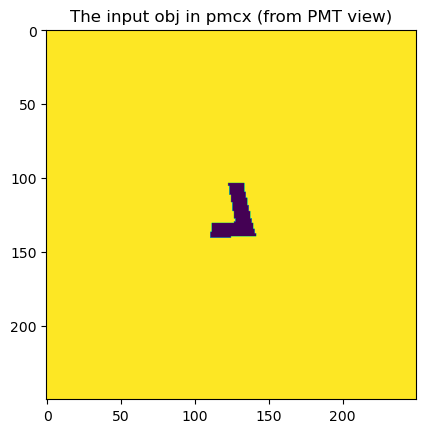

In [3]:
#--------------note the MCX output is from the PMT view-------------
obj_in_mcx = cv2.resize(obj_img_5x5, (50,50), interpolation=cv2.INTER_NEAREST)
obj_in_mcx_PMT = np.flip(obj_in_mcx,1)  # flip the obj to make sure that the obj is form the PMT view

obj_in_mcx_PMT_padding = cv2.copyMakeBorder(
    obj_in_mcx_PMT, 
    100, 100, 100, 100,                 # the padding range form four sides
    cv2.BORDER_CONSTANT, 
    value=1                             # the padding value
)

obj_in_mcx_PMT_padding = np.uint8(obj_in_mcx_PMT_padding)

# %matplotlib inline
plt.figure()
plt.imshow(obj_in_mcx_PMT_padding)
plt.title('The input obj in pmcx (from PMT view)')
plt.show()

#==========================creating the MCX volume=====================
thickness = 50 # mm
unitinmm = 1
t_vox = int(thickness/unitinmm)
vol = np.ones([250,250,t_vox+1],dtype='uint8')
vol[:,:,-1] = 0
vol[:,:,24] = np.rot90(obj_in_mcx_PMT_padding,k = -1,axes = (0,1)) # rotate the input OBJ in the MCX to make sure shape is correct

#===========================MCX cfg================================
try:
    cfg.clear()
except NameError:
    pass  

cfg = {'nphoton': 1e7, 
       'vol': vol, 
       'tstart':0, 
        'tend':12.1e-9, # 10.1
        'tstep':0.1e-9, # 100 ps resolution
       'srcpos': [10,125,0], 
       'srcdir':[0,0,1],
       'unitinmm':unitinmm,
       # 'detpos': [125, 125, t_vox, 4], #radius approx 1mm (4vox) (fibre ~2mm from sample)
       'issrcfrom0':1,
       'issavedet':1,
       'issaveref':1
       }


cfg['prop'] = [[0,0,1,1],           # background
               [0.0019, 1.4800,0,1.44], # volume 1
               ]

## sens and IRF

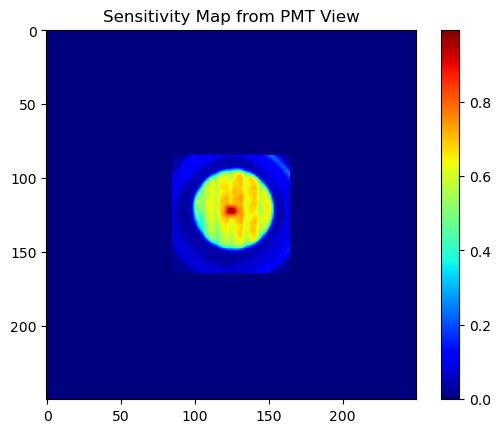

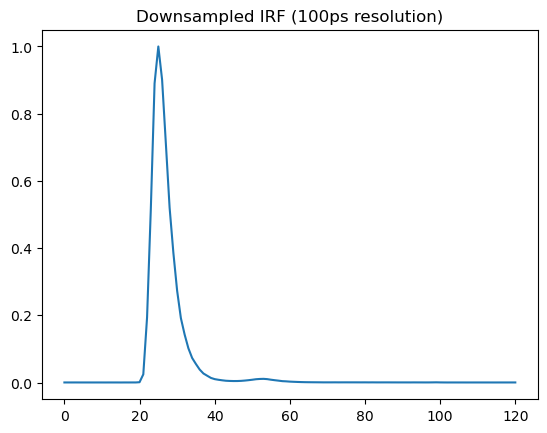

In [4]:
#-----------------prepare the sensitibity map-------------
sems_path = os.path.join(data_fold,r'sensitivity_map_gain0.7_8x8cm_51x51points_binWidth15ps_expo0.1sec_binNum2000_40deg_061224.npy')
sensitivity = np.load(sems_path).sum(2)

#================binary the sensitivity map================
# sensitivity = sensitivity-0.3*np.max(sensitivity)
# sensitivity[sensitivity<0] = 0
# sensitivity[sensitivity>0] = 1

sensitivity = sensitivity/sensitivity.max()                                 # normalize the sensitivity map 
sensitivity = np.fliplr(sensitivity)                                        # flip to make sure the sensitivity map is from PMT view
sensitivity = resize(sensitivity, (80,80), interpolation=cv2.INTER_LINEAR)  # resize to (80,80) to match the (8x8)cm FOV
sens_pad = np.zeros((250,250))
sens_pad[125-40:125+40, 125-40:125+40] = sensitivity

plt.figure()
plt.imshow(sens_pad,'jet')
plt.title('Sensitivity Map from PMT View')
plt.colorbar()
plt.show()

#-----------------prepare the IRF---------------------
IRF_path = os.path.join(data_fold,r'IRF_gain0.7_timebin15ps_2000bins_061224.npy')
IRF = np.load(IRF_path)[:1000]
IRF_down = resize(IRF[:np.round(121*100/15).astype('int')], (1, 121), interpolation=cv2.INTER_NEAREST_EXACT)
IRF_down= np.squeeze(IRF_down)
IRF_down = IRF_down/IRF_down.max()      # normalize the IRF
plt.figure()
plt.plot(IRF_down)
plt.title('Downsampled IRF (100ps resolution)')
plt.show()

## main sim

In [9]:
pmcx_exp_L_3x3 = np.zeros((3,3,121))

src_x_positions = np.linspace(125+25,125-25,pmcx_exp_L_3x3.shape[0])          # from PMT view, from right to left
src_y_positions = np.linspace(125+25,125-25,pmcx_exp_L_3x3.shape[0])          # from PMT view, from up to down

# ==================scan the laser point=================
# note i is row, which is Y, j is column in numpy array, which in pmcx means X
for i, pos_y in tqdm(enumerate(src_y_positions)):
    for j, pos_x in tqdm(enumerate(src_x_positions)):
        cfg['srcpos'] = [pos_x, pos_y, 0]
        res = pmcx.run(cfg)
        dref_bd = res['dref'][:,:,int(vol.shape[2]-1),:]                    # get the boundary value
        dref_bd_rot = np.rot90(dref_bd, k=1, axes = (0,1))                  # rotate the output to get correct angle
        pmcx_exp_L_3x3[i,j,:] = (dref_bd_rot*sens_pad[:,:,None]).sum((0,1))     # apply the sensitivity map
            
pmcx_exp_L_3x3 = np.apply_along_axis(lambda m: fftconvolve(m, IRF_down, mode='full'), axis=2, arr=pmcx_exp_L_3x3)[:,:,:len(IRF_down)]
pmcx_exp_L_3x3 = pmcx_exp_L_3x3/pmcx_exp_L_3x3.max()
np.save('F:/OneDrive/foam_imaging_project/pmcx_foam/experiment_data/sim_MCX_obj_L_3x3.npy',pmcx_exp_L_3x3)     


0it [00:00, ?it/s]

nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
issavedet: 1


nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
issavedet: 1


nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
issavedet: 1


3it [00:13,  4.47s/it]
1it [00:13, 13.41s/it]

nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
issavedet: 1


nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
issavedet: 1


nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
issavedet: 1


3it [00:12,  4.09s/it]
2it [00:25, 12.74s/it]

nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
issavedet: 1


nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
issavedet: 1


nphoton: 1e+07
tstart: 0
tstep: 1e-10
tend: 1.21e-08
issrcfrom0: 1
unitinmm: 1
issaveref: 1
issavedet: 1


3it [00:12,  4.16s/it]
3it [00:38, 12.72s/it]


## compare

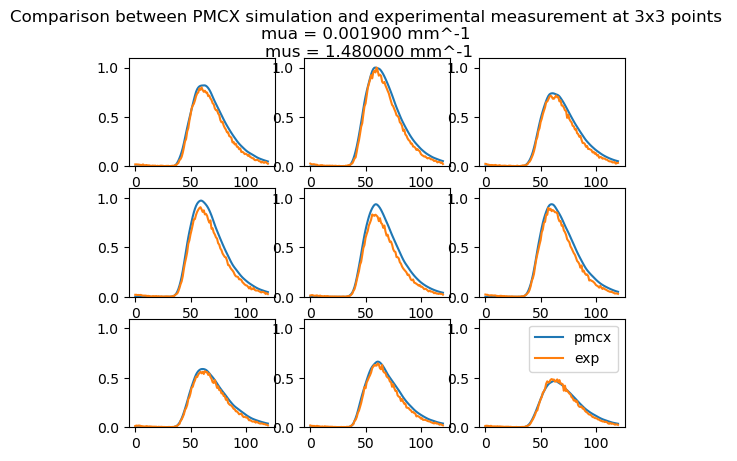

In [8]:
exp = np.load(os.path.join(data_fold,r'L_gain0.7_5x5cm_31x31points_pol50deg_expo0.5sec_binWidth15ps_binNum2000_061224.npy'))

exp_down = np.zeros((31, 31, 121))
for i in range(31):
    for j in range(31):
        exp_down[i,j,:] = np.squeeze(resize(exp[i,j,:np.round(121*100/15).astype('int')], (1, 121), 
                                             interpolation=cv2.INTER_NEAREST_EXACT))
exp_down = exp_down/exp_down.max()

exp_down_3x3 = np.zeros((3,3,121))
for i, xi in enumerate([0, 15, 30]):
    for j, yj in enumerate([0,15,30]):
        exp_down_3x3[i,j,:] = exp_down[xi,yj,:]
exp_down_3x3 = exp_down_3x3/exp_down_3x3.max()

plt.figure()

for i, index_i in enumerate([0, 15, 30]):
    for j,index_j in enumerate([0, 15, 30]):
        plt.subplot(3,3,3*i+j+1)
        # plt.plot(y[i,j,:], label='data')
        plt.plot(pmcx_exp_L_3x3[i,j,:], label='pmcx')
        plt.plot(exp_down_3x3[i,j,:], label='exp')
        plt.ylim([0,1.1])
plt.legend()

plt.suptitle(
    f"Comparison between PMCX simulation and experimental measurement at 3x3 points \n"
    f"mua = {cfg['prop'][1][0]:.6f} mm^-1 \n"
    f"mus = {cfg['prop'][1][1]:.6f} mm^-1"
)

plt.show()